# DiD and Event-Study: Synthetic Cash-Drag Nudges

This notebook demonstrates a causal workflow on a **synthetic** dataset calibrated to cash drag in rollover IRAs.

Focus:
- Synthetic data with realistic frictions (selection bias, non-compliance, overlapping nudges)
- Difference-in-Differences (DiD) with staggered rollout
- Event-study for pre-trend diagnostics and dynamic effects


### Variable Names Used In Charts (Reader-Friendly)
- `Any Nudge Exposure`: account was exposed to at least one nudge channel in a month.
- `Investment Action (Observed)`: observed monthly investment action indicator.
- `Months Since Rollover`: lifecycle month relative to rollover date.
- `Event Time`: month relative to first nudge exposure.


In [1]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import get_ipython

RANDOM_SEED = 42
DATA_PATH = "data/did_ready.csv"

# Full sample is the default for final analysis.
USE_FULL_SAMPLE = True
DEBUG_SAMPLE_ACCOUNTS = 8000

ip = get_ipython()
if ip is not None:
    ip.run_line_magic("matplotlib", "inline")

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120
sns.set_theme(style="whitegrid")


In [2]:

full = pd.read_csv(DATA_PATH)
full = full[full["active_flag"] == 1].copy()

if USE_FULL_SAMPLE:
    df = full.copy()
else:
    unique_accounts = full["account_id"].drop_duplicates()
    sample_accounts = unique_accounts.sample(n=DEBUG_SAMPLE_ACCOUNTS, random_state=RANDOM_SEED)
    df = full[full["account_id"].isin(sample_accounts)].copy()

first_exposure = (
    df[df["treatment_any"] == 1]
    .groupby("account_id")["calendar_month"].min()
    .rename("first_exposure_month")
)

df = df.merge(first_exposure, on="account_id", how="left")

df["event_time"] = df["calendar_month"] - df["first_exposure_month"]

df["treated"] = df["first_exposure_month"].notna().astype(int)

df["post"] = (
    (df["treated"] == 1)
    & (df["calendar_month"] >= df["first_exposure_month"])
).astype(int)

print("Rows:", len(df))
print("Unique accounts:", df["account_id"].nunique())
print("Months range:", df["calendar_month"].min(), "-", df["calendar_month"].max())
print("Full sample mode:", USE_FULL_SAMPLE)

df.head()


Rows: 1525260
Unique accounts: 50000
Months range: 1 - 36
Full sample mode: True


,account_id,calendar_month,months_since_rollover,treated,post,event_time,treatment_any,treatment_intensity,invested_flag,invest_amount,active_flag,eligible_flag,first_exposure_month
0,36,1,0,0,0,NaN,0,0,0,0.00000,1,0,NaN
1,45,1,0,0,0,NaN,0,0,1,4723.41582,1,0,NaN
2,56,1,0,1,0,-3.0,0,0,0,0.00000,1,0,4.0
3,69,1,0,1,0,-5.0,0,0,0,0.00000,1,0,6.0
4,104,1,0,1,0,-1.0,0,0,0,0.00000,1,0,2.0


## Quick EDA (high level)
We just want to see if treatment and investment rates are in a reasonable range.

Invest rate (monthly): 0.0415
Share ever treated (account-level): 0.173


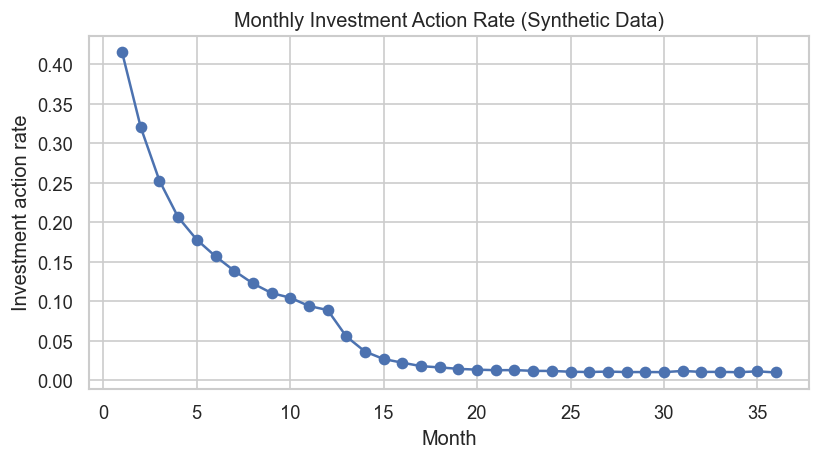

In [3]:
invest_rate = df["invested_flag"].mean()
share_treated = df.groupby("account_id")["treated"].max().mean()

print(f"Invest rate (monthly): {invest_rate:.4f}")
print(f"Share ever treated (account-level): {share_treated:.3f}")

monthly = df.groupby("calendar_month")["invested_flag"].mean().reset_index()

plt.figure(figsize=(7, 4))
plt.plot(monthly["calendar_month"], monthly["invested_flag"], marker="o")
plt.title("Monthly Investment Action Rate (Synthetic Data)")
plt.xlabel("Month")
plt.ylabel("Investment action rate")
plt.tight_layout()
plt.show()


In [4]:
# Coverage and eligibility checks
# These sanity checks help show the synthetic data behaves like a real operational dataset.

print("Accounts:", df["account_id"].nunique())
print("Avg months per account:", df.groupby("account_id")["calendar_month"].count().mean())
print("Active share:", df["active_flag"].mean())
print("Eligible share:", df["eligible_flag"].mean())


Accounts: 50000
Avg months per account: 30.5052
Active share: 1.0
Eligible share: 0.05254972922649253


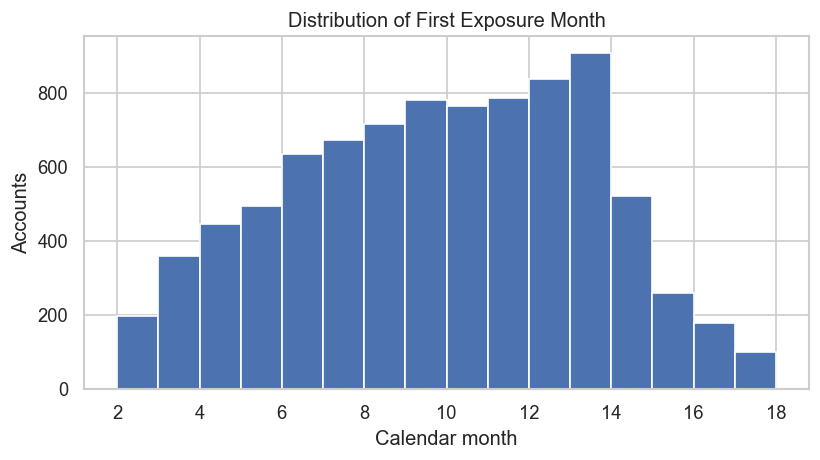

In [5]:
# Timing of first exposure
# Use first_exposure_month directly so the plot reflects treatment timing.

exposure_timing = (
    df.loc[df["treated"] == 1, ["account_id", "first_exposure_month"]]
    .drop_duplicates()["first_exposure_month"]
)

plt.figure(figsize=(7, 4))
plt.hist(exposure_timing, bins=sorted(exposure_timing.unique()))
plt.title("Distribution of First Exposure Month")
plt.xlabel("Calendar month")
plt.ylabel("Accounts")
plt.tight_layout()
plt.show()


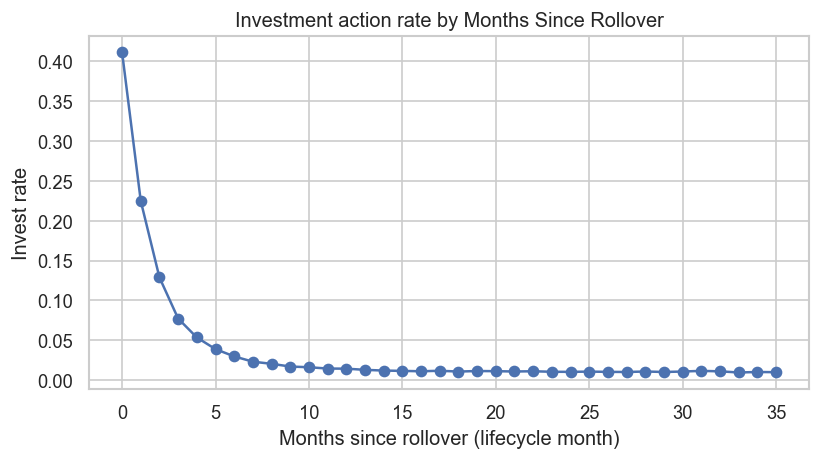

In [6]:
# Invest rate by months since rollover
# This should generally decline as time passes without action (cash drag behavior).

msr_rate = df.groupby("months_since_rollover")["invested_flag"].mean()

plt.figure(figsize=(7, 4))
plt.plot(msr_rate.index, msr_rate.values, marker="o")
plt.title("Investment action rate by Months Since Rollover")
plt.xlabel("Months since rollover (lifecycle month)")
plt.ylabel("Invest rate")
plt.tight_layout()
plt.show()


In [7]:
# Missingness and follow-up coverage checks

missing = df.isna().mean().sort_values(ascending=False)
print("Top missingness rates:")
print(missing.head(10))

# Accounts enter at different rollover months, so follow-up length varies by construction.
follow_up_months = df.groupby("account_id")["calendar_month"].count()
print("Mean follow-up months per account:", round(follow_up_months.mean(), 2))
print("Min/Max follow-up months:", int(follow_up_months.min()), int(follow_up_months.max()))


Top missingness rates:
event_time               0.830346
first_exposure_month     0.830346
account_id               0.000000
calendar_month           0.000000
months_since_rollover    0.000000
treated                  0.000000
post                     0.000000
treatment_any            0.000000
treatment_intensity      0.000000
invested_flag            0.000000
dtype: float64
Mean follow-up months per account: 30.51
Min/Max follow-up months: 25 36


## Optional: Channel overlap (requires `account_month.csv`)
This file is larger, so load only what you need. This is a realism check for overlapping nudges.

In [8]:
# Optional: overlap of exposures by month
# Load only the necessary columns to keep memory reasonable.

panel = pd.read_csv(
    "data/account_month.csv",
    usecols=["exposure_email", "exposure_sms", "exposure_inapp"],
)

panel["n_channels_exposed"] = panel[["exposure_email", "exposure_sms", "exposure_inapp"]].sum(axis=1)
print(panel["n_channels_exposed"].value_counts(normalize=True).sort_index())


0    0.994207
1    0.005500
2    0.000284
3    0.000008
Name: n_channels_exposed, dtype: float64


## Two-way Fixed Effects DiD
We use a simple **linear probability model (LPM)** with two-way fixed effects:
- **Account FE**: removes time-invariant differences across accounts.
- **Month FE**: absorbs common shocks (market, seasonality).

We implement this via **two-way demeaning** to avoid creating huge dummy matrices.

In [9]:
def twoway_demean(frame: pd.DataFrame, cols, entity_col, time_col):
    overall = frame[cols].mean()
    entity_means = frame.groupby(entity_col)[cols].transform("mean")
    time_means = frame.groupby(time_col)[cols].transform("mean")
    return frame[cols] - entity_means - time_means + overall


In [10]:
df["did"] = df["treated"] * df["post"]

demeaned = twoway_demean(df, ["invested_flag", "did"], "account_id", "calendar_month")

Y = demeaned["invested_flag"]
X = demeaned[["did"]]

model = sm.OLS(Y, X).fit(cov_type="cluster", cov_kwds={"groups": df["account_id"]})
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:          invested_flag   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                          1.897e+04
Date:                Tue, 10 Feb 2026   Prob (F-statistic):                        0.00
Time:                        00:03:02   Log-Likelihood:                      3.7695e+05
No. Observations:             1525260   AIC:                                 -7.539e+05
Df Residuals:                 1525259   BIC:                                 -7.539e+05
Df Model:                           1                                                  
Covariance Type:              cluster                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

## Segment Lift (Same Monthly DiD Estimand as Slide 14)
We estimate the **same two-way FE DiD model** separately by baseline balance segment.
This is what feeds slide 14. Error bars are **95% CIs** (`coef ± 1.96 * SE`).

In [11]:
# Build baseline balance segments at the account level.
accounts = pd.read_csv('data/accounts.csv', usecols=['account_id', 'baseline_balance'])
accounts['balance_band'] = pd.qcut(accounts['baseline_balance'], q=3, labels=['Low', 'Mid', 'High'])
balance_band_map = accounts.set_index('account_id')['balance_band']

seg_frame = df[['account_id', 'calendar_month', 'invested_flag', 'did']].copy()
seg_frame['balance_band'] = seg_frame['account_id'].map(balance_band_map)

segment_rows = []
for band in ['Low', 'Mid', 'High']:
    block = seg_frame[seg_frame['balance_band'] == band].copy()

    # Same estimand as the main TWFE DiD cell, run within each segment.
    dm = twoway_demean(block, ['invested_flag', 'did'], 'account_id', 'calendar_month')
    reg = sm.OLS(dm['invested_flag'], dm[['did']]).fit(
        cov_type='cluster', cov_kwds={'groups': block['account_id']}
    )

    segment_rows.append({
        'band': band,
        'coef': float(reg.params['did']),
        'se': float(reg.bse['did']),
        'n_accounts': int(block['account_id'].nunique()),
        'n_rows': int(len(block)),
    })

segment_did = pd.DataFrame(segment_rows)
segment_did['lift_pp'] = 100.0 * segment_did['coef']
segment_did['ci95_low_pp'] = segment_did['lift_pp'] - 1.96 * 100.0 * segment_did['se']
segment_did['ci95_high_pp'] = segment_did['lift_pp'] + 1.96 * 100.0 * segment_did['se']

segment_did[['band', 'lift_pp', 'ci95_low_pp', 'ci95_high_pp', 'n_accounts']].round(3)

,band,lift_pp,ci95_low_pp,ci95_high_pp,n_accounts
0,Low,15.181,14.837,15.524,16667
1,Mid,16.663,16.252,17.073,16666
2,High,17.416,16.937,17.896,16667


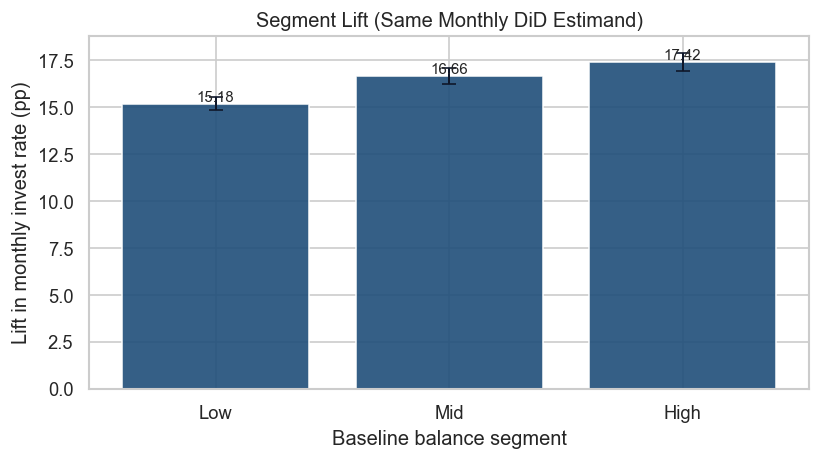

In [12]:
plot_df = segment_did.set_index('band').reindex(['Low', 'Mid', 'High']).reset_index()
x = np.arange(len(plot_df))
y = plot_df['lift_pp'].to_numpy()
yerr = 1.96 * 100.0 * plot_df['se'].to_numpy()

plt.figure(figsize=(7, 4))
plt.axhline(0, color='black', linewidth=1)
plt.bar(x, y, color='#1F4E79', alpha=0.9)
plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='#0F172A', capsize=4, linewidth=1.2)
plt.xticks(x, plot_df['band'])
plt.title('Segment Lift (Same Monthly DiD Estimand)')
plt.xlabel('Baseline balance segment')
plt.ylabel('Lift in monthly invest rate (pp)')
for i, v in enumerate(y):
    plt.text(i, v + 0.15, f'{v:.2f}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

## Event-Study (Dynamic Effects + Pre-trend Check)
We estimate event-time coefficients (k = -6..+12) relative to **k = -1** as the baseline.

Why this matters:
- The **pre-period coefficients** should be close to zero if the parallel trends assumption is plausible.
- The **post-period coefficients** show the timing and durability of the effect.

In [13]:
window = list(range(-6, 13))
base = -1

event_time = df["event_time"]

for k in window:
    if k == base:
        continue
    df[f"evt_{k}"] = (event_time == k).astype(int)

event_cols = [f"evt_{k}" for k in window if k != base]

demeaned_es = twoway_demean(df, ["invested_flag"] + event_cols, "account_id", "calendar_month")

Y_es = demeaned_es["invested_flag"]
X_es = demeaned_es[event_cols]

es_model = sm.OLS(Y_es, X_es).fit(cov_type="cluster", cov_kwds={"groups": df["account_id"]})

coefs = es_model.params
ses = es_model.bse

coef_df = pd.DataFrame({
    "k": [int(c.replace("evt_", "")) for c in event_cols],
    "coef": coefs.values,
    "se": ses.values,
})
coef_df["lower"] = coef_df["coef"] - 1.96 * coef_df["se"]
coef_df["upper"] = coef_df["coef"] + 1.96 * coef_df["se"]
coef_df = coef_df.sort_values("k")

coef_df.head()


,k,coef,se,lower,upper
0,-6,-0.181197,0.007756,-0.196399,-0.165995
1,-5,-0.163445,0.004571,-0.172404,-0.154485
2,-4,-0.150755,0.002903,-0.156446,-0.145064
3,-3,-0.136684,0.002533,-0.141649,-0.131720
4,-2,-0.132994,0.001789,-0.136500,-0.129487


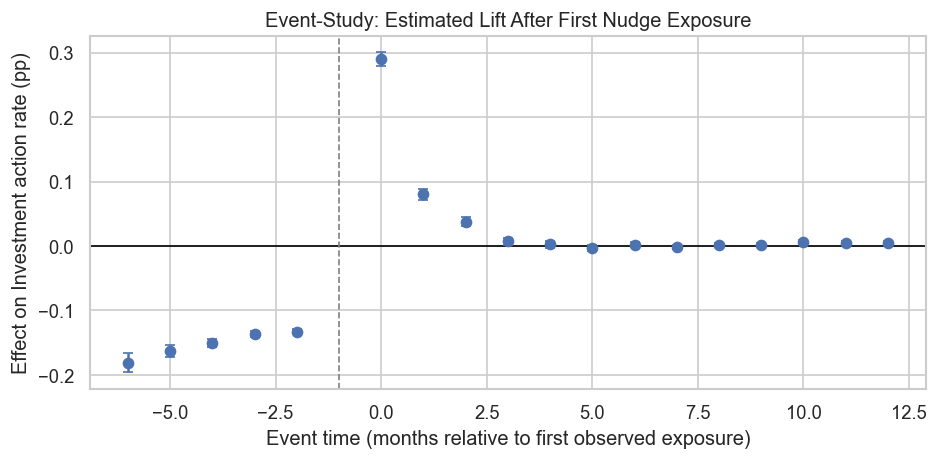

In [14]:
plt.figure(figsize=(8, 4))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(-1, color="gray", linestyle="--", linewidth=1)

plt.errorbar(
    coef_df["k"],
    coef_df["coef"],
    yerr=1.96 * coef_df["se"],
    fmt="o",
    capsize=3,
)

plt.title("Event-Study: Estimated Lift After First Nudge Exposure")
plt.xlabel("Event time (months relative to first observed exposure)")
plt.ylabel("Effect on Investment action rate (pp)")
plt.tight_layout()
plt.show()


## Robustness Checks (Round 1)
These checks stress-test the DiD/event-study without switching to ITS or RD.
They are designed to be quick to run and easy to interpret for a panel interview.

In [15]:
pre_cols = [c for c in event_cols if c.startswith("evt_-")]

pre_test = es_model.f_test(" = 0, ".join(pre_cols) + " = 0")
print(pre_test)


<F test: F=1621.6116596620575, p=0.0, df_denom=5e+04, df_num=5>


## Pre-trend Mitigation: Eventually-Treated Cohorts
When targeting is strong, baseline and never-treated groups can have different trends.
This sensitivity check restricts to eventually-treated cohorts and uses not-yet-treated periods as controls.

In [16]:
# Restrict to eventually-treated cohorts (not-yet-treated periods remain valid controls)
acct_treated = df.groupby("account_id")["treated"].max()
ever_treated_ids = acct_treated[acct_treated == 1].index
nyt_es = df[df["account_id"].isin(ever_treated_ids)].copy()

window_nyt = list(range(-6, 13))
base_nyt = -1
for k in window_nyt:
    if k == base_nyt:
        continue
    nyt_es[f"nyt_evt_{k}"] = (nyt_es["event_time"] == k).astype(int)

nyt_event_cols = [f"nyt_evt_{k}" for k in window_nyt if k != base_nyt]

nyt_dm = twoway_demean(nyt_es, ["invested_flag"] + nyt_event_cols, "account_id", "calendar_month")
nyt_model_es = sm.OLS(nyt_dm["invested_flag"], nyt_dm[nyt_event_cols]).fit(
    cov_type="cluster", cov_kwds={"groups": nyt_es["account_id"]}
)

nyt_pre_cols = [c for c in nyt_event_cols if c.startswith("nyt_evt_-")]
nyt_pre_test = nyt_model_es.f_test(" = 0, ".join(nyt_pre_cols) + " = 0")
print(nyt_pre_test)


<F test: F=1.4117324724644444, p=0.2164351975073364, df_denom=8.64e+03, df_num=5>


## Diagram: Baseline vs Corrected Pre-trends
The chart below compares event-study coefficients before and after the cohort-based correction.

In [17]:
pretrend_compare = pd.DataFrame({
    "specification": ["Baseline full sample", "Eventually-treated cohorts"],
    "pretrend_p_value": [float(pre_test.pvalue), float(nyt_pre_test.pvalue)],
})
pretrend_compare


,specification,pretrend_p_value
0,Baseline full sample,0.000000
1,Eventually-treated cohorts,0.216435


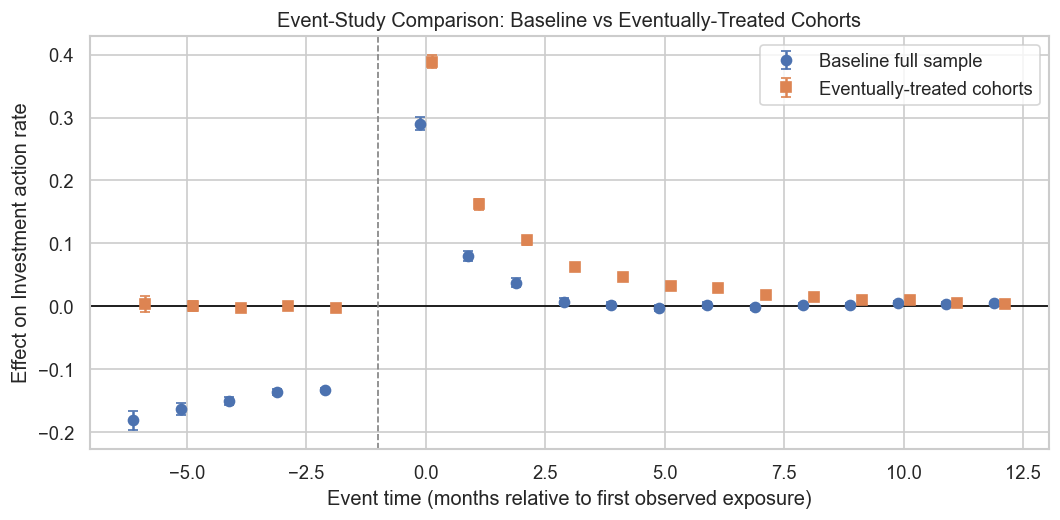

In [18]:
nyt_coef_df = pd.DataFrame({
    "k": [int(c.replace("nyt_evt_", "")) for c in nyt_event_cols],
    "coef": nyt_model_es.params.values,
    "se": nyt_model_es.bse.values,
})

base_plot_df = coef_df[["k", "coef", "se"]].copy()

plt.figure(figsize=(9, 4.5))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(-1, color="gray", linestyle="--", linewidth=1)

offset = 0.12
plt.errorbar(
    base_plot_df["k"] - offset,
    base_plot_df["coef"],
    yerr=1.96 * base_plot_df["se"],
    fmt="o",
    capsize=3,
    label="Baseline full sample",
)

plt.errorbar(
    nyt_coef_df["k"] + offset,
    nyt_coef_df["coef"],
    yerr=1.96 * nyt_coef_df["se"],
    fmt="s",
    capsize=3,
    label="Eventually-treated cohorts",
)

plt.title("Event-Study Comparison: Baseline vs Eventually-Treated Cohorts")
plt.xlabel("Event time (months relative to first observed exposure)")
plt.ylabel("Effect on Investment action rate")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
placebo = df.copy()

placebo["placebo_post"] = (placebo["event_time"].fillna(-999) >= -6).astype(int)
placebo["placebo_treated"] = placebo["treated"]
placebo["placebo_did"] = placebo["placebo_treated"] * placebo["placebo_post"]

placebo_dm = twoway_demean(placebo, ["invested_flag", "placebo_did"], "account_id", "calendar_month")
Y_p = placebo_dm["invested_flag"]
X_p = placebo_dm[["placebo_did"]]

placebo_model = sm.OLS(Y_p, X_p).fit(cov_type="cluster", cov_kwds={"groups": placebo["account_id"]})
print(placebo_model.summary())


                                 OLS Regression Results                                
Dep. Variable:          invested_flag   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              23.26
Date:                Tue, 10 Feb 2026   Prob (F-statistic):                    1.42e-06
Time:                        00:03:06   Log-Likelihood:                      3.7066e+05
No. Observations:             1525260   AIC:                                 -7.413e+05
Df Residuals:                 1525259   BIC:                                 -7.413e+05
Df Model:                           1                                                  
Covariance Type:              cluster                                                  
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

In [20]:
acct_treated = df.groupby("account_id")["treated"].max()

ever_treated_ids = acct_treated[acct_treated == 1].index

nyt = df[df["account_id"].isin(ever_treated_ids)].copy()

nyt["did"] = nyt["treated"] * nyt["post"]
nyt_dm = twoway_demean(nyt, ["invested_flag", "did"], "account_id", "calendar_month")
Y_n = nyt_dm["invested_flag"]
X_n = nyt_dm[["did"]]

nyt_model = sm.OLS(Y_n, X_n).fit(cov_type="cluster", cov_kwds={"groups": nyt["account_id"]})
print(nyt_model.summary())


                                 OLS Regression Results                                
Dep. Variable:          invested_flag   R-squared (uncentered):                   0.031
Model:                            OLS   Adj. R-squared (uncentered):              0.031
Method:                 Least Squares   F-statistic:                          1.314e+04
Date:                Tue, 10 Feb 2026   Prob (F-statistic):                        0.00
Time:                        00:03:06   Log-Likelihood:                          61810.
No. Observations:              258767   AIC:                                 -1.236e+05
Df Residuals:                  258766   BIC:                                 -1.236e+05
Df Model:                           1                                                  
Covariance Type:              cluster                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [21]:
single = df[df["treatment_intensity"] <= 1].copy()

single["did"] = single["treated"] * single["post"]

single_dm = twoway_demean(single, ["invested_flag", "did"], "account_id", "calendar_month")
Y_s = single_dm["invested_flag"]
X_s = single_dm[["did"]]

single_model = sm.OLS(Y_s, X_s).fit(cov_type="cluster", cov_kwds={"groups": single["account_id"]})
print(single_model.summary())


                                 OLS Regression Results                                
Dep. Variable:          invested_flag   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                          1.859e+04
Date:                Tue, 10 Feb 2026   Prob (F-statistic):                        0.00
Time:                        00:03:07   Log-Likelihood:                      3.7928e+05
No. Observations:             1524733   AIC:                                 -7.586e+05
Df Residuals:                 1524732   BIC:                                 -7.586e+05
Df Model:                           1                                                  
Covariance Type:              cluster                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [22]:
trim = df[((df["event_time"] >= -6) & (df["event_time"] <= 6)) | (df["treated"] == 0)].copy()
trim["did"] = trim["treated"] * trim["post"]

trim_dm = twoway_demean(trim, ["invested_flag", "did"], "account_id", "calendar_month")
Y_t = trim_dm["invested_flag"]
X_t = trim_dm[["did"]]

trim_model = sm.OLS(Y_t, X_t).fit(cov_type="cluster", cov_kwds={"groups": trim["account_id"]})
print(trim_model.summary())


                                 OLS Regression Results                                
Dep. Variable:          invested_flag   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                          1.952e+04
Date:                Tue, 10 Feb 2026   Prob (F-statistic):                        0.00
Time:                        00:03:08   Log-Likelihood:                      2.8093e+05
No. Observations:             1346856   AIC:                                 -5.619e+05
Df Residuals:                 1346855   BIC:                                 -5.618e+05
Df Model:                           1                                                  
Covariance Type:              cluster                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

## Alternative: Treatment Intensity
Because there are multiple nudges, we can estimate a marginal effect per channel exposure.
This is a **robustness check**, not the primary causal estimate.

In [23]:
# Two-way FE with treatment intensity
# Interpretation: marginal effect of each additional channel exposure in a month

cols_intensity = ["invested_flag", "treatment_intensity"]

demeaned_intensity = twoway_demean(df, cols_intensity, "account_id", "calendar_month")
Y_i = demeaned_intensity["invested_flag"]
X_i = demeaned_intensity[["treatment_intensity"]]

intensity_model = sm.OLS(Y_i, X_i).fit(cov_type="cluster", cov_kwds={"groups": df["account_id"]})
print(intensity_model.summary())


                                 OLS Regression Results                                
Dep. Variable:          invested_flag   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              3093.
Date:                Tue, 10 Feb 2026   Prob (F-statistic):                        0.00
Time:                        00:03:08   Log-Likelihood:                      3.8172e+05
No. Observations:             1525260   AIC:                                 -7.634e+05
Df Residuals:                 1525259   BIC:                                 -7.634e+05
Df Model:                           1                                                  
Covariance Type:              cluster                                                  
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------


## Modern Staggered DiD: Callaway-Sant'Anna-Style `ATT(g,t)`
We compute cohort-time effects manually using first-treatment cohort `g` and calendar month `t`.

Definition used:
- `ATT(g,t) = E[Y_t - Y_{g-1} | G=g] - E[Y_t - Y_{g-1} | controls at t]`
- Controls are **not-yet-treated + never-treated** units at month `t`.

This directly addresses a known TWFE issue under heterogeneous effects by using valid control sets for each cohort-time comparison.


In [24]:

# Build account-level first-treatment cohort (g) and wide outcome matrix.
acct = (
    df[["account_id", "first_exposure_month"]]
    .drop_duplicates("account_id")
    .rename(columns={"first_exposure_month": "g"})
)

# Keep g as nullable integer where available.
acct["g"] = pd.to_numeric(acct["g"], errors="coerce")

y_wide = df.pivot(index="account_id", columns="calendar_month", values="invested_flag")
g_by_acct = acct.set_index("account_id")["g"].reindex(y_wide.index)

months = sorted(df["calendar_month"].dropna().astype(int).unique())
max_month = max(months)

treated_cohorts = sorted(g_by_acct.dropna().astype(int).unique())
window_cs = list(range(-6, 13))

records = []
for g in treated_cohorts:
    base = g - 1
    if base not in y_wide.columns:
        continue

    group_mask = (g_by_acct == g)
    if group_mask.sum() == 0:
        continue

    y_base_g = y_wide.loc[group_mask, base]

    for e in window_cs:
        if e == -1:
            continue
        t = g + e
        if (t < 1) or (t > max_month) or (t not in y_wide.columns):
            continue

        # Cohort g differences
        diff_g = (y_wide.loc[group_mask, t] - y_base_g).dropna()
        if len(diff_g) == 0:
            continue

        # Not-yet-treated + never-treated controls at month t, excluding cohort g itself
        control_mask = ((g_by_acct.isna()) | (g_by_acct > t)) & (~group_mask)
        if control_mask.sum() == 0:
            continue

        diff_c = (y_wide.loc[control_mask, t] - y_wide.loc[control_mask, base]).dropna()
        if len(diff_c) == 0:
            continue

        att_gt = diff_g.mean() - diff_c.mean()

        records.append({
            "g": g,
            "t": t,
            "e": e,
            "att": float(att_gt),
            "n_treated": int(len(diff_g)),
            "n_control": int(len(diff_c)),
        })

cs_gt = pd.DataFrame(records)
print("Cohort-time cells:", len(cs_gt))
print("Cohorts used:", cs_gt["g"].nunique())
cs_gt.head()


Cohort-time cells: 291
Cohorts used: 17


,g,t,e,att,n_treated,n_control
0,2,2,0,0.668645,197,4001
1,2,3,1,0.524091,197,3854
2,2,4,2,0.489462,197,3773
3,2,5,3,0.474224,197,3731
4,2,6,4,0.467897,197,3688


In [25]:

# Aggregate ATT(g,t) by event time e (CS-style dynamic path) using treated-cell weights.
def wmean(x, w):
    x = np.asarray(x)
    w = np.asarray(w)
    return np.sum(w * x) / np.sum(w)


def wvar(x, w):
    x = np.asarray(x)
    w = np.asarray(w)
    mu = wmean(x, w)
    return np.sum(w * (x - mu) ** 2) / np.sum(w)


cs_event_rows = []
for e, block in cs_gt.groupby("e"):
    w = block["n_treated"].to_numpy()
    x = block["att"].to_numpy()
    att_e = wmean(x, w)
    # Cohort-dispersion SE (descriptive, not IF-based CS variance)
    se_disp = np.sqrt(wvar(x, w) / max(len(x), 1))
    cs_event_rows.append({
        "e": int(e),
        "att": float(att_e),
        "se_disp": float(se_disp),
        "n_cells": int(len(block)),
        "n_treated_weight": float(w.sum()),
    })

cs_event = pd.DataFrame(cs_event_rows).sort_values("e")

# Headline post ATT over e>=0
post_block = cs_gt[cs_gt["e"] >= 0]
cs_post_att = wmean(post_block["att"], post_block["n_treated"]) if len(post_block) else np.nan

# Pre-window summary over e<=-2
pre_block = cs_gt[cs_gt["e"] <= -2]
cs_pre_mean = wmean(pre_block["att"], pre_block["n_treated"]) if len(pre_block) else np.nan

print(f"CS-style post ATT (e>=0): {cs_post_att:.4f}")
print(f"CS-style pre mean (e<=-2): {cs_pre_mean:.4f}")
cs_event.head()


CS-style post ATT (e>=0): 0.1883
CS-style pre mean (e<=-2): -0.0858


,e,att,se_disp,n_cells,n_treated_weight
0,-6,-0.150055,0.025223,12,379.0
1,-5,-0.132139,0.023426,13,946.0
2,-4,-0.114678,0.018529,14,1820.0
3,-3,-0.088475,0.015074,15,3017.0
4,-2,-0.060571,0.010964,16,5097.0


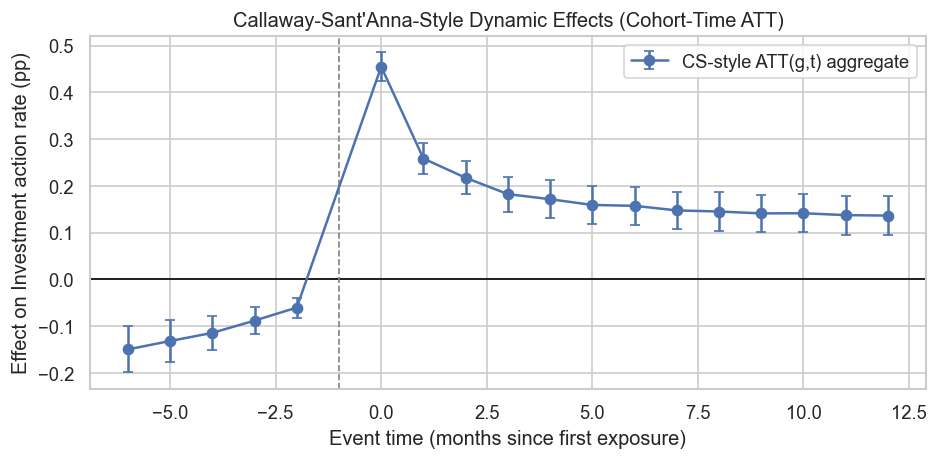

In [26]:

plt.figure(figsize=(8, 4))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(-1, color="gray", linestyle="--", linewidth=1)

plt.errorbar(
    cs_event["e"],
    cs_event["att"],
    yerr=1.96 * cs_event["se_disp"],
    fmt="o-",
    capsize=3,
    label="CS-style ATT(g,t) aggregate",
)

plt.title("Callaway-Sant'Anna-Style Dynamic Effects (Cohort-Time ATT)")
plt.xlabel("Event time (months since first exposure)")
plt.ylabel("Effect on Investment action rate (pp)")
plt.legend()
plt.tight_layout()
plt.show()



## Modern Staggered DiD: Sun-Abraham-Style Interaction-Weighted Dynamics
Sun-Abraham aggregates cohort-specific dynamic effects (`CATT(g,e)`) with interaction weights.

Here we use the same cohort-event cells and apply **cohort-size interaction weights** by event time.
This gives a dynamic path that is robust to the main TWFE contamination mechanism under heterogeneous effects.


In [27]:

# Cohort sizes among ever-treated accounts
cohort_sizes = (
    g_by_acct.dropna().astype(int).value_counts().rename_axis("g").reset_index(name="n_g")
)
cohort_sizes = cohort_sizes.set_index("g")["n_g"]

sa_rows = []
for e, block in cs_gt.groupby("e"):
    g_vals = block["g"].astype(int).to_numpy()
    catt = block["att"].to_numpy()

    # Sun-Abraham-style interaction weights proportional to cohort size
    w_raw = np.array([cohort_sizes.get(g, 0) for g in g_vals], dtype=float)
    if w_raw.sum() == 0:
        continue
    w = w_raw / w_raw.sum()

    sa_att_e = float(np.sum(w * catt))
    # Descriptive dispersion only
    sa_se_disp = float(np.sqrt(np.sum(w * (catt - sa_att_e) ** 2) / max(len(catt), 1)))

    sa_rows.append({
        "e": int(e),
        "att": sa_att_e,
        "se_disp": sa_se_disp,
        "n_cells": int(len(block)),
    })

sa_event = pd.DataFrame(sa_rows).sort_values("e")

sa_post = sa_event[sa_event["e"] >= 0]
sa_post_att = float(np.average(sa_post["att"], weights=np.maximum(sa_post["n_cells"], 1))) if len(sa_post) else np.nan

print(f"SA-style post ATT (e>=0): {sa_post_att:.4f}")
sa_event.head()


SA-style post ATT (e>=0): 0.1883


,e,att,se_disp,n_cells
0,-6,-0.170374,0.025842,12
1,-5,-0.159905,0.025394,13
2,-4,-0.138663,0.020583,14
3,-3,-0.103805,0.016681,15
4,-2,-0.066659,0.011786,16


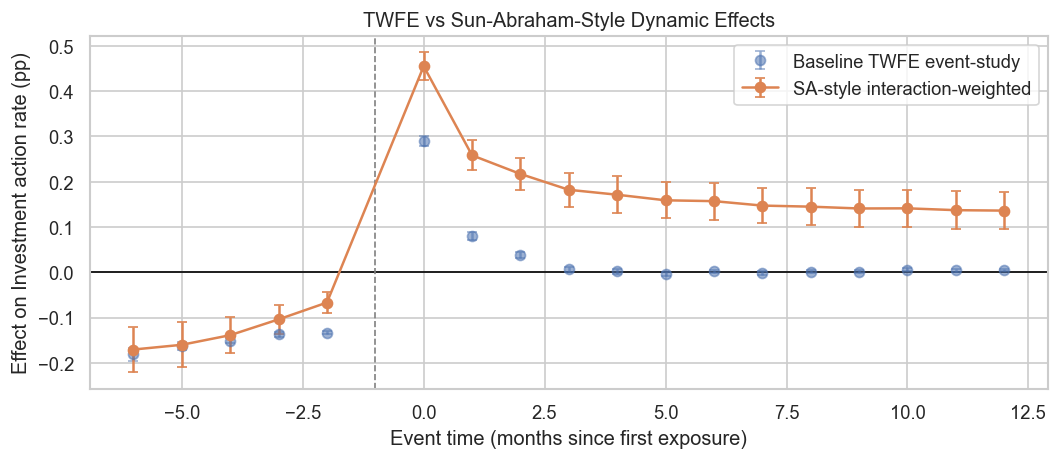

In [28]:

# Compare baseline TWFE event-study vs SA-style interaction-weighted event-study.
twfe_plot = coef_df[["k", "coef", "se"]].copy().rename(columns={"k": "e", "coef": "att", "se": "se"})
sa_plot = sa_event.copy().rename(columns={"se_disp": "se"})

plt.figure(figsize=(9, 4))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(-1, color="gray", linestyle="--", linewidth=1)

plt.errorbar(
    twfe_plot["e"],
    twfe_plot["att"],
    yerr=1.96 * twfe_plot["se"],
    fmt="o",
    alpha=0.55,
    capsize=3,
    label="Baseline TWFE event-study",
)

plt.errorbar(
    sa_plot["e"],
    sa_plot["att"],
    yerr=1.96 * sa_plot["se"],
    fmt="o-",
    capsize=3,
    label="SA-style interaction-weighted",
)

plt.title("TWFE vs Sun-Abraham-Style Dynamic Effects")
plt.xlabel("Event time (months since first exposure)")
plt.ylabel("Effect on Investment action rate (pp)")
plt.legend()
plt.tight_layout()
plt.show()



## Estimand and Interpretation
- **Baseline TWFE (all-sample)** estimates a blended contrast where controls are mostly never-treated units.
  In this notebook, this design is diagnostic-only because baseline pre-trends and placebo timing checks are problematic.

- **Eventually-treated FE / not-yet-treated controls** targets a **within-target-population ATT-style estimand**:
  the effect among accounts that are eventually nudged, comparing post-exposure periods to their own pre-exposure periods.

- This is **not** the same as a portfolio-wide ATE for all rollover IRA accounts.
  Magnitudes should not be directly compared to account-level 12-month IPW/DR estimates without noting the estimand difference.



## Notes and Caveats
- **Parallel trends** should be assessed visually and with pre-period tests.
- We report both **baseline TWFE** and modern staggered-adoption alternatives:
  - Callaway-Sant'Anna-style `ATT(g,t)` aggregation
  - Sun-Abraham-style interaction-weighted dynamics
- The CS/SA uncertainty bands shown here are **cohort-dispersion bands** for fast notebook diagnostics.
  In production, use package-level influence-function or bootstrap inference.
- The dataset is **synthetic but realistic**, including selection bias and non-compliance.
  This is intentional to show robustness and sound causal reasoning.
